In [26]:
from mobster_mv import mobster_MV
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy.stats import pareto, beta, uniform, norm


import torch
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
def plot_deltas(mb):
    deltas = mb.params["delta"]
    fig, ax = plt.subplots(nrows=deltas.shape[0], ncols=1)
    fig.tight_layout()
    for k in range(deltas.shape[0]):
        sns.heatmap(deltas[k], ax=ax[k], vmin=0, vmax=1, cmap="crest")
        ax[k].set(xlabel="Distributions (0=Pareto, 1=Beta)", ylabel="Dimensions")
        ax[k].set_title(f"Cluster {k}")

def plot_paretos(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    for k in range(alpha_pareto.shape[0]):
        for d in range(alpha_pareto.shape[1]):
            pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.001)
            ax[k,d].plot(x, pdf, 'r-', lw=1)
            ax[k,d].set_title(f"Cluster {k} Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    for k in range(phi_beta.shape[0]):
        for d in range(phi_beta.shape[1]):
            a = phi_beta[k,d]*kappa_beta[k,d]
            b = (1-phi_beta[k,d])*kappa_beta[k,d]
            pdf = beta.pdf(x, a, b)
            ax[k,d].plot(x, pdf, 'r-', lw=1)
            ax[k,d].set_title(f"Cluster {k} Dimension {d}") 
            
def plot_marginals(mb, NV, DP):
    df = pd.DataFrame({'values': NV[:,0].numpy()/DP[:,0].numpy(), 'cluster': mb.params["cluster_assignments"].numpy()})
    sns.kdeplot(data=df, x='values', hue='cluster', fill=True)
    plt.title('S1 Marginal distribution')
    plt.show()
    df = pd.DataFrame({'values': NV[:,1].numpy()/DP[:,1].numpy(), 'cluster': mb.params["cluster_assignments"].numpy()})
    sns.kdeplot(data=df, x='values', hue='cluster', fill=True)
    plt.title('S2 Marginal distribution')
    plt.show()

In [58]:
def plot_priors():
    # fig.tight_layout()
    x = np.arange(0,1,0.001)
    for _ in range(15):
        phi_beta = dist.Uniform(0., 1.).sample().numpy()
        k_beta = dist.Normal(200, 0.5).sample().numpy()
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        pdf = beta.pdf(x, a_beta, b_beta)
        plt.plot(x, pdf, 'r-', lw=1)
        plt.title("Beta prior")
    plt.show()
    x = np.arange(0,1,0.001)
    for _ in range(15):
        alpha = dist.LogNormal(0.7, 0.1).sample().numpy()
        pdf = pareto.pdf(x, alpha, scale = 0.01)
        plt.plot(x, pdf, 'r-', lw=1)
        plt.title("Pareto prior")
    plt.show()

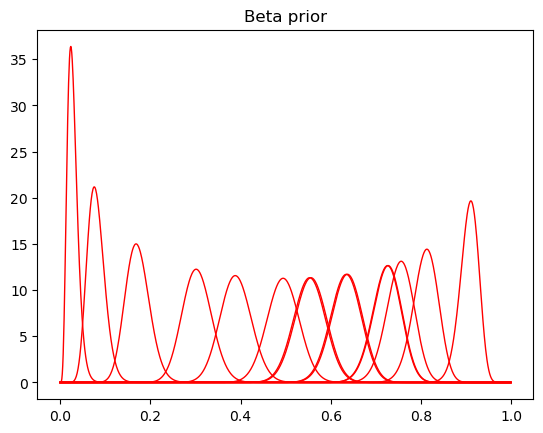

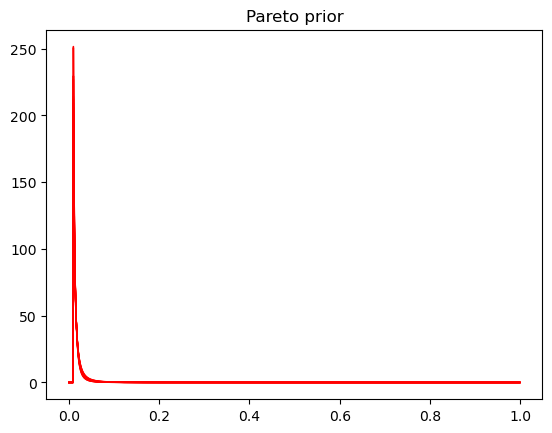

In [62]:
plot_priors()

In [90]:
N1 = 2000
N2 = 1000
seed = 12
# NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.2, n=100, N=N1, seed = seed)
# NV2, DP2 = beta_binomial_component(p_x=0.8, p_y=0.6, n=150, N=N2, seed=seed)
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, phi_beta = 0.2, k_beta = 200, n=100, N=N1, seed = seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([3000, 2])
torch.Size([3000, 2])


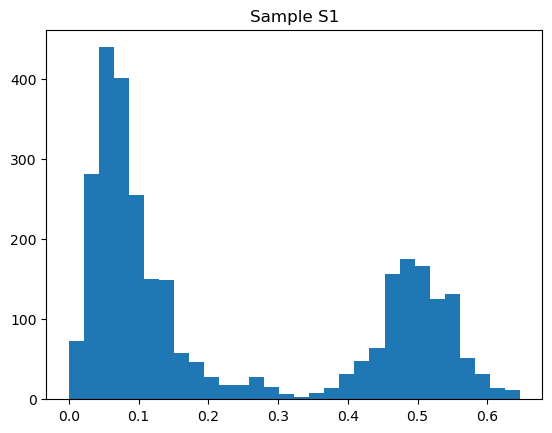

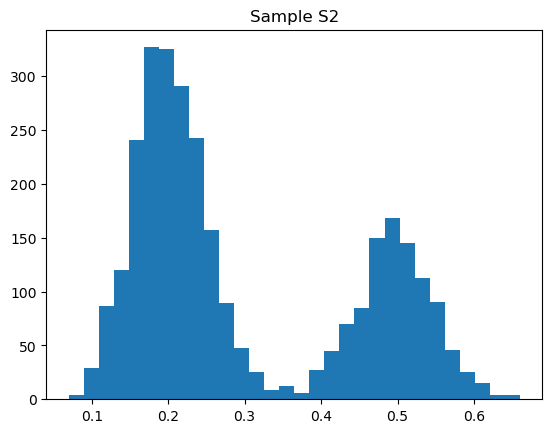

In [92]:
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 30)
plt.title("Sample S1")
plt.show()

plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 30)
plt.title("Sample S2")
plt.show()

In [65]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

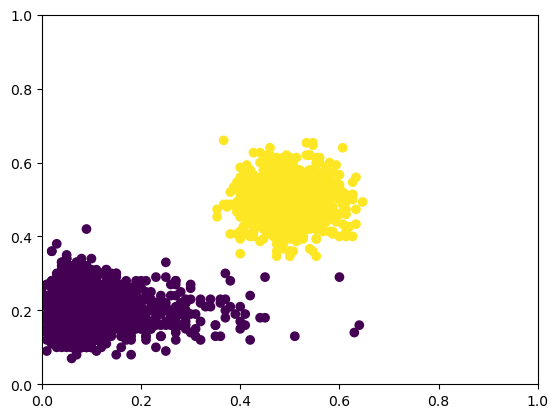

In [66]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0908, 0.1989],
        [0.5006, 0.4935]])
Iteration 0: Loss = inf
Iteration 200: Loss = 125514136.0
Iteration 400: Loss = 82244328.0
Iteration 600: Loss = 65886168.0
Iteration 800: Loss = 55154992.0
Iteration 1000: Loss = 41952452.0
Iteration 1200: Loss = 35123340.0
Iteration 1400: Loss = 29064480.0
Iteration 1600: Loss = 23145314.0
Iteration 1800: Loss = 18366574.0
Iteration 2000: Loss = 15314872.0
Iteration 2200: Loss = 13461572.0
Iteration 2400: Loss = 12275992.0
Iteration 2600: Loss = 11454064.0
Iteration 2800: Loss = 10852064.0
Iteration 3000: Loss = 10432781.0
Iteration 3200: Loss = 10137676.0
Iteration 3400: Loss = 9934176.0
Iteration 3600: Loss = 9779532.0
Iteration 3800: Loss = 9669867.0


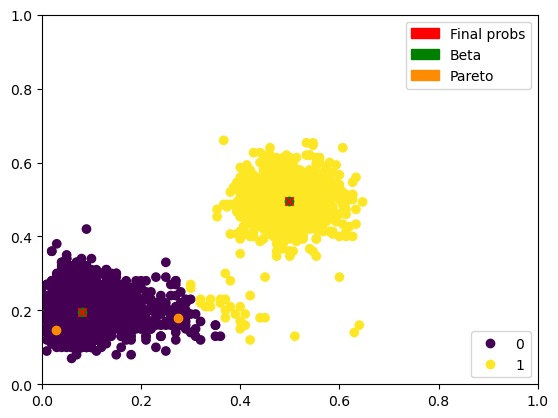

In [87]:
mb = mobster_MV(NV, DP, K = 2, seed = 12)
mb.fit(num_iter = 4000, lr = 0.001)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

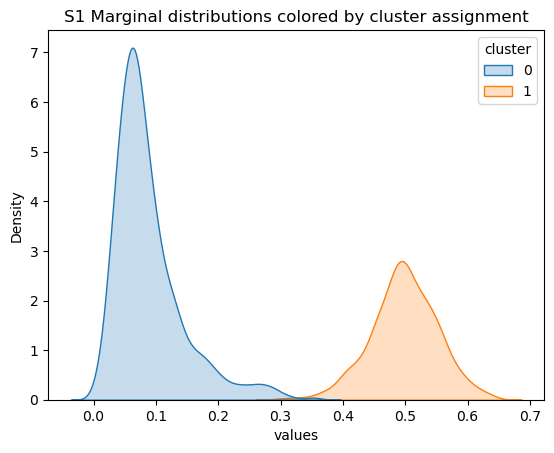

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

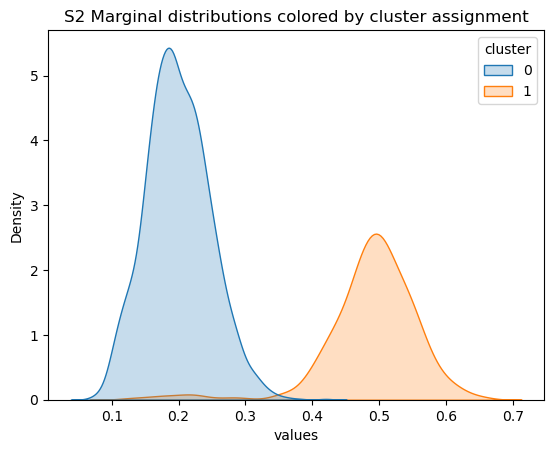

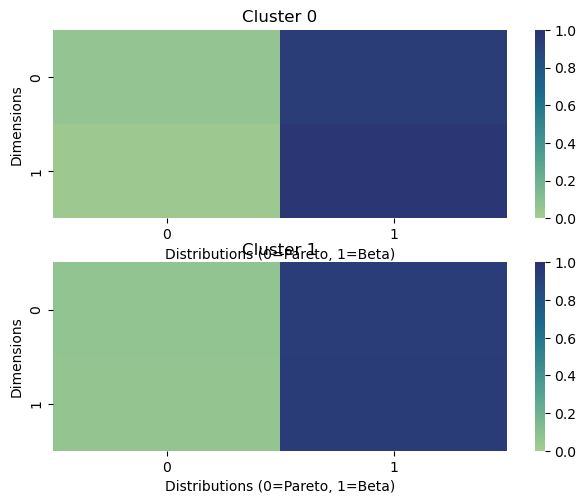

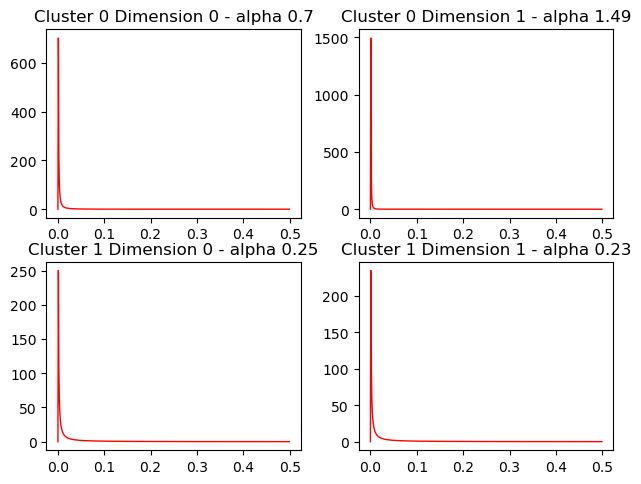

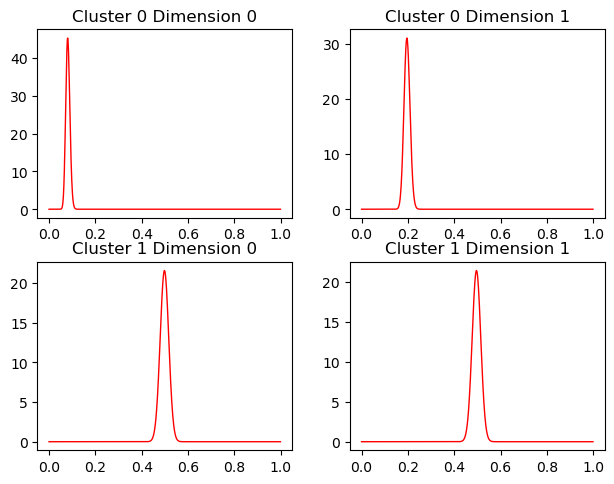

In [100]:
plot_marginals(mb, NV, DP)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [71]:
mb.params

{'probs_beta': tensor([[0.0808, 0.1960],
         [0.4982, 0.4961]]),
 'probs_pareto': tensor([[0.0291, 0.1463],
         [0.2745, 0.1785]]),
 'weights': tensor([0.6443, 0.3557]),
 'delta': tensor([[[0.0649, 0.9351],
          [0.0309, 0.9691]],
 
         [[0.0698, 0.9302],
          [0.0597, 0.9403]]]),
 'alpha_pareto': tensor([[0.7026, 1.4937],
         [0.2500, 0.2347]]),
 'phi_beta': tensor([[0.0812, 0.1964],
         [0.4982, 0.4961]]),
 'k_beta': tensor([[953.3245, 951.7062],
         [731.9249, 722.2427]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [7.8292e-29, 1.4171e-34, 1.7508e-25,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00]]),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

In [88]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.9181804042312728


### Using 3 components

In [15]:
N1 = 2000
N2 = 1000
N3 = 2000

NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, phi_beta = 0.5, k_beta = 200, n=100, N=N1, seed = seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([5000, 2])
torch.Size([5000, 2])


In [16]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

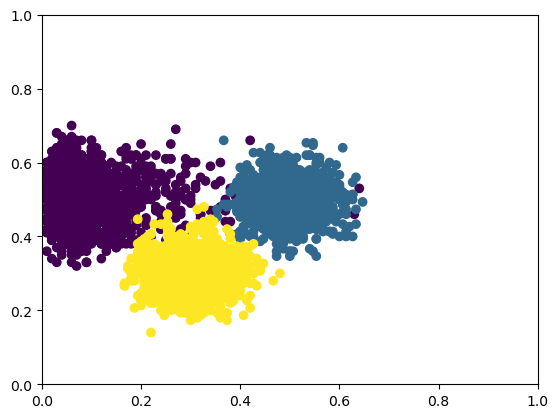

In [17]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0847, 0.5020],
        [0.2999, 0.3028],
        [0.4971, 0.4977]])
Iteration 0: Loss = inf
Iteration 200: Loss = 237054688.0
Iteration 400: Loss = 184949392.0
Iteration 600: Loss = 150176864.0
Iteration 800: Loss = 126859072.0
Iteration 1000: Loss = 102116392.0
Iteration 1200: Loss = 84627104.0
Iteration 1400: Loss = 70176024.0
Iteration 1600: Loss = 60072424.0
Iteration 1800: Loss = 53327300.0
Iteration 2000: Loss = 48713104.0
Iteration 2200: Loss = 45396904.0
Iteration 2400: Loss = 42840004.0
Iteration 2600: Loss = 40725860.0
Iteration 2800: Loss = 38945244.0
Iteration 3000: Loss = 37455888.0
Iteration 3200: Loss = 36271552.0
Iteration 3400: Loss = 35381280.0
Iteration 3600: Loss = 34809020.0
Iteration 3800: Loss = 34460832.0
Iteration 4000: Loss = 34257896.0
Iteration 4200: Loss = 34093600.0
Iteration 4400: Loss = 34022296.0
Iteration 4600: Loss = 33945708.0
Iteration 4800: Loss = 33864176.0


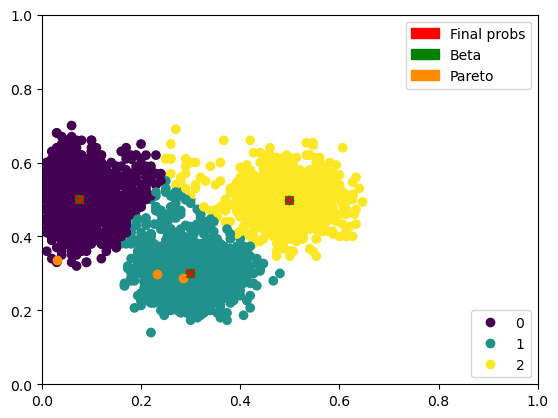

In [18]:
mb = mobster_MV(NV, DP, K = 3, seed = 12)
mb.fit(num_iter = 5000, lr = 0.001)

In [19]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.8945370611559015


In [20]:
mb.params

{'probs_beta': tensor([[0.0745, 0.5014],
         [0.2981, 0.3020],
         [0.4986, 0.4993]]),
 'probs_pareto': tensor([[0.0312, 0.3375],
         [0.2842, 0.2873],
         [0.2330, 0.2993]]),
 'weights': tensor([0.3714, 0.4113, 0.2173]),
 'delta': tensor([[[0.0303, 0.9697],
          [0.0094, 0.9906]],
 
         [[0.0045, 0.9955],
          [0.0058, 0.9942]],
 
         [[0.0488, 0.9512],
          [0.0050, 0.9950]]]),
 'alpha_pareto': tensor([[0.8263, 0.2221],
         [1.8612, 1.8616],
         [0.2107, 0.2391]]),
 'phi_beta': tensor([[0.0749, 0.5014],
         [0.2983, 0.3021],
         [0.4986, 0.4993]]),
 'k_beta': tensor([[1180.8292, 1182.0664],
         [1237.0371, 1237.4489],
         [ 910.2305,  930.3420]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.0740e-17, 6.3297e-23,
          4.4181e-25],
         [1.5028e-13, 4.3019e-16, 5.7771e-11,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [7.1430e-19, 4.5668e-21, 5.1449e-21,  ..., 7.76

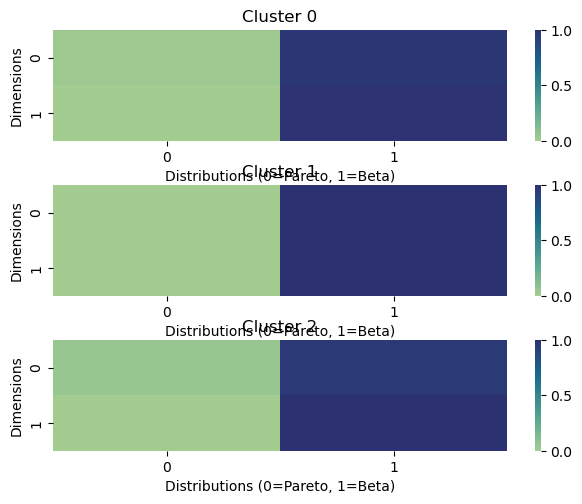

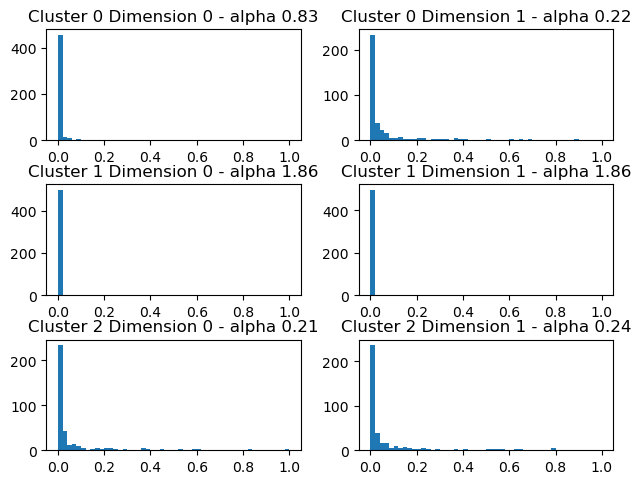

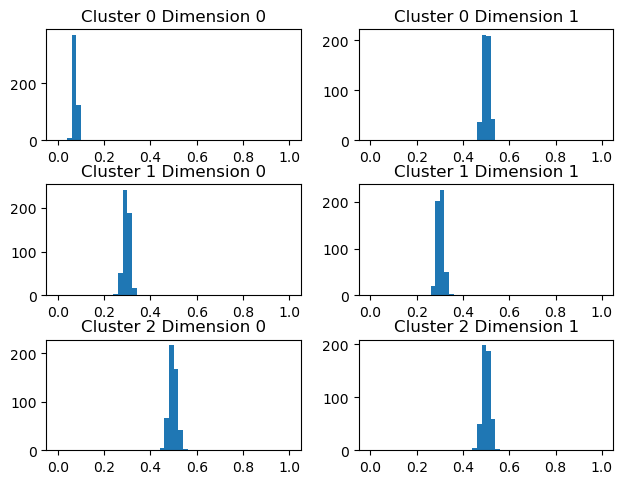

In [21]:
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### Using 4 components (1 beta private)

In [66]:
seed = 123
N1 = 2000
N2 = 1000
N3 = 2000
N4 = 1000

NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, phi_beta = 0.5, k_beta = 200, n=100, N=N1, seed = seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)
NV4, DP4 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.00001, k_beta_y= 250, n=150, N=N4, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
NV = torch.concat((NV,NV4))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
DP = torch.concat((DP,DP4))
print(DP.shape)
# print(DP) 

torch.Size([6000, 2])
torch.Size([6000, 2])


In [67]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3
labels_4 = np.ones(N4) * 4

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))
labels = np.concatenate((labels, labels_4))

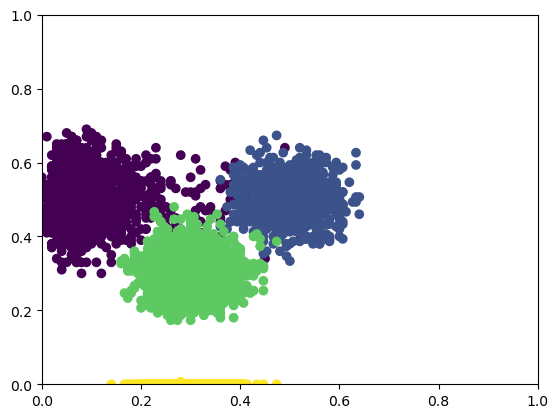

In [68]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[8.5548e-02, 5.0117e-01],
        [2.9954e-01, 7.5996e-06],
        [2.9841e-01, 3.0305e-01],
        [4.9642e-01, 4.9917e-01]])
Iteration 0: Loss = inf
Iteration 200: Loss = 524057728.0
Iteration 400: Loss = 406983744.0
Iteration 600: Loss = 308865664.0
Iteration 800: Loss = 207549936.0
Iteration 1000: Loss = 87059360.0
Iteration 1200: Loss = -73350136.0
Iteration 1400: Loss = -306153984.0
Iteration 1600: Loss = -664438400.0
Iteration 1800: Loss = -1236458880.0
Iteration 2000: Loss = -2217552128.0
Iteration 2200: Loss = inf
Iteration 2400: Loss = inf
Iteration 2600: Loss = inf
Iteration 2800: Loss = inf


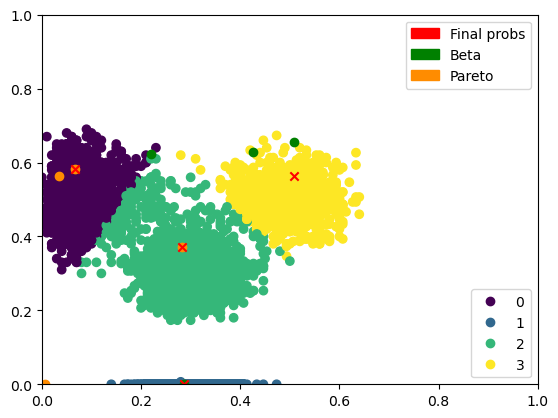

In [69]:
mb = mobster_MV(NV, DP, K = 4, seed = 12)
mb.fit(num_iter = 3000, lr = 0.001)

In [70]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.8879996586761119


In [73]:
mb.params

{'probs_beta': tensor([[2.2072e-01, 6.2431e-01],
         [2.8650e-01, 6.3406e-05],
         [4.2664e-01, 6.2916e-01],
         [5.0756e-01, 6.5595e-01]]),
 'probs_pareto': tensor([[6.7388e-02, 5.8189e-01],
         [6.4332e-03, 2.2140e-08],
         [2.8197e-01, 3.7198e-01],
         [3.3971e-02, 5.6247e-01]]),
 'weights': tensor([0.0664, 0.7626, 0.1114, 0.0596]),
 'delta': tensor([[[0.5407, 0.4593],
          [0.8528, 0.1472]],
 
         [[0.4498, 0.5502],
          [0.9430, 0.0570]],
 
         [[0.5763, 0.4237],
          [0.6125, 0.3875]],
 
         [[0.3506, 0.6494],
          [0.9420, 0.0580]]]),
 'alpha_pareto': tensor([[5.0280e-01, 4.7285e-01],
         [5.1024e-01, 9.3182e+02],
         [4.7818e-01, 4.7736e-01],
         [1.8841e+00, 4.6820e-01]]),
 'phi_beta': tensor([[0.2227, 0.6230],
         [0.2869, 0.0972],
         [0.4272, 0.6280],
         [0.5091, 0.6544]]),
 'k_beta': tensor([[200.0005, 200.0006],
         [560.3806, 199.8454],
         [200.0001, 200.0006],
    

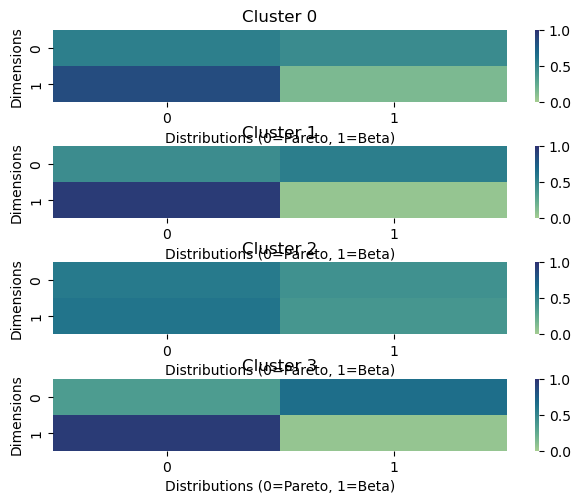

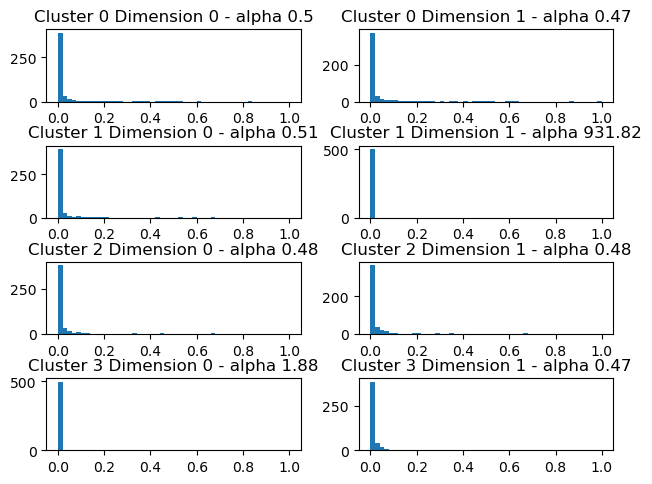

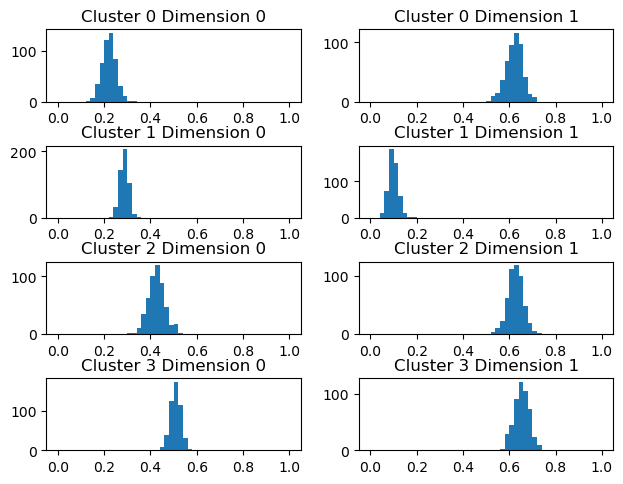

In [72]:
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### rRACES data

In [2]:
NV_r = pd.read_csv("NV2.csv")
DP_r = pd.read_csv("DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)


torch.Size([593, 2])
torch.Size([593, 2])


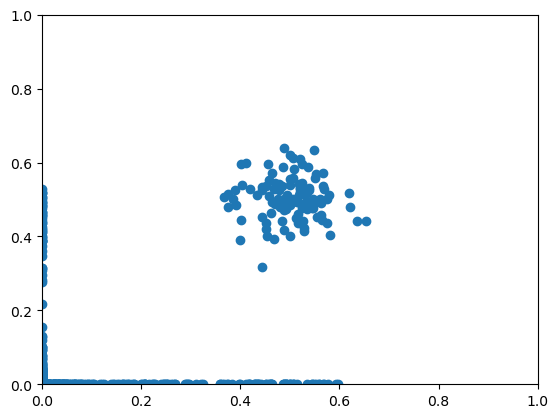

In [3]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

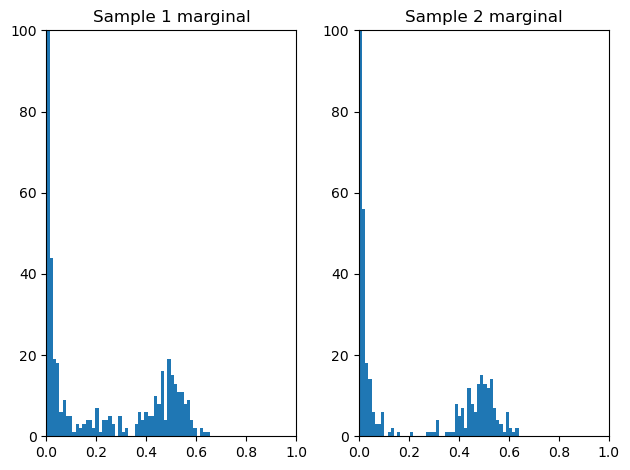

In [4]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
mb = mobster_MV(NV, DP, K = 5, seed = 13)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Iteration 0: Loss = inf
Iteration 200: Loss = -64364692.0
Iteration 400: Loss = -89653984.0
Iteration 600: Loss = -123254856.0
Iteration 800: Loss = -175255568.0
Iteration 1000: Loss = -265837600.0
Iteration 1200: Loss = -395408288.0
Iteration 1400: Loss = -584295040.0
Iteration 1600: Loss = -865722432.0
Iteration 1800: Loss = -1291088512.0
Iteration 2000: Loss = -1940793088.0
Iteration 2200: Loss = -2941150464.0
Iteration 2400: Loss = -4491089920.0
Iteration 2600: Loss = -6904536064.0
Iteration 2800: Loss = -10677713920.0
Iteration 3000: Loss = -16595985408.0
Iteration 3200: Loss = -25903665152.0
Iteration 3400: Loss = -40573968384.0
Iteration 3600: Loss = -63738122240.0
Iteration 3800: Loss = -100368048128.0
Iteration 4000: Loss = -158362320896.0
Iteration 4200: Loss = -250272890880.0
Iteration 4400: Loss = -396054265856.0
Iteration 4600: Loss = -627438911488.0
Iteration 4800: Loss = -994897756160.0


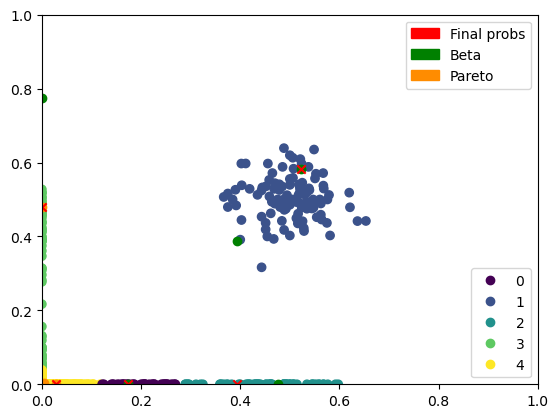

In [10]:
mb.fit(num_iter = 5000, lr = 0.001)

In [ ]:
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [11]:
# Without small gaussian noise
mb.params

{'probs_beta': tensor([[1.7350e-01, 1.1755e-38],
         [5.2200e-01, 5.8361e-01],
         [3.9311e-01, 3.8766e-01],
         [2.0136e-10, 7.7391e-01],
         [4.7554e-01, 1.1755e-38]]),
 'probs_pareto': tensor([[1.5572e-03, 1.1755e-38],
         [4.7107e-03, 4.7597e-03],
         [6.4283e-06, 6.2085e-06],
         [1.3284e-08, 4.7840e-01],
         [2.9081e-02, 1.1755e-38]]),
 'weights': tensor([0.0062, 0.0026, 0.0081, 0.0013, 0.9819]),
 'delta': tensor([[[0.4573, 0.5427],
          [0.1000, 0.9000]],
 
         [[0.0599, 0.9401],
          [0.3685, 0.6315]],
 
         [[0.2929, 0.7071],
          [0.6187, 0.3813]],
 
         [[0.5581, 0.4419],
          [0.7673, 0.2327]],
 
         [[0.6122, 0.3878],
          [0.5969, 0.4031]]]),
 'alpha_pareto': tensor([[2.0418e+00, 2.7178e+00],
         [1.4745e+00, 1.4710e+00],
         [9.5518e+02, 9.9258e+02],
         [4.6917e+00, 1.0965e+00],
         [2.8298e-01, 5.5819e+04]]),
 'phi_beta': tensor([[1.7764e-01, 1.1755e-38],
         [

### rRACES longitudinal data

In [36]:
NV_r = pd.read_csv("NV_long.csv")
DP_r = pd.read_csv("DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


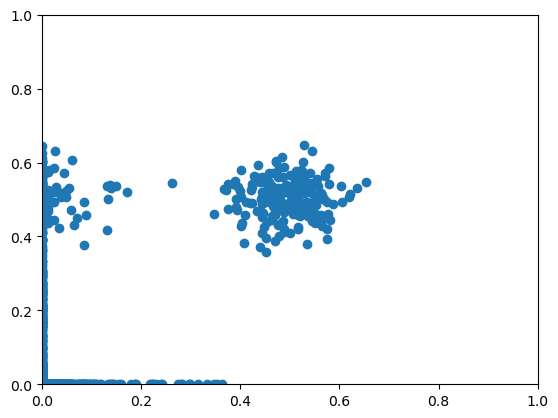

In [37]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

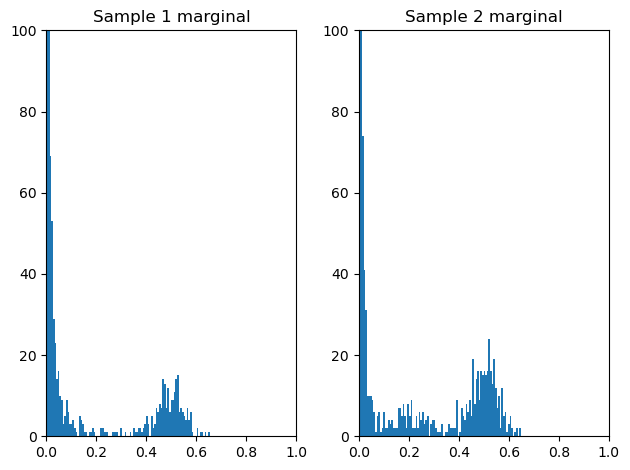

In [38]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[ 4.9358e-01,  5.0280e-01],
        [ 1.4901e-08,  1.9570e-01],
        [ 1.7599e-02,  5.2229e-01],
        [ 1.4503e-02,  1.1386e-02],
        [ 2.2913e-01, -1.4901e-08],
        [ 6.7374e-03,  3.6865e-01]])
Iteration 0: Loss = inf
Iteration 200: Loss = -237213232.0
Iteration 400: Loss = -299152288.0
Iteration 600: Loss = -382960576.0
Iteration 800: Loss = -508211648.0
Iteration 1000: Loss = inf
Iteration 1200: Loss = inf
Iteration 1400: Loss = inf
Iteration 1600: Loss = inf
Iteration 1800: Loss = inf
Iteration 2000: Loss = inf
Iteration 2200: Loss = inf
Iteration 2400: Loss = inf
Iteration 2600: Loss = inf
Iteration 2800: Loss = inf
Iteration 3000: Loss = inf
Iteration 3200: Loss = inf
Iteration 3400: Loss = -134182903808.0
Iteration 3600: Loss = -210843648000.0
Iteration 3800: Loss = -332067438592.0
Iteration 4000: Loss = -523994169344.0
Iteration 4200: Loss = -828164145152.0
Iteration 4400: Loss = -1310612127744.0
Iteration 4600: Loss = -2076356116480.0
Ite

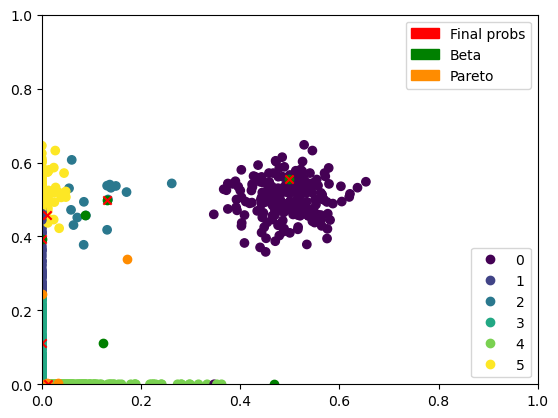

In [40]:
mb = mobster_MV(NV, DP, K = 6, seed = 1234)
mb.fit(num_iter = 5000, lr = 0.001)

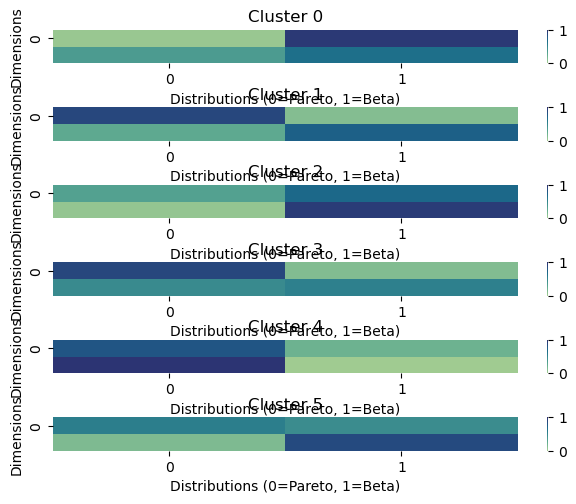

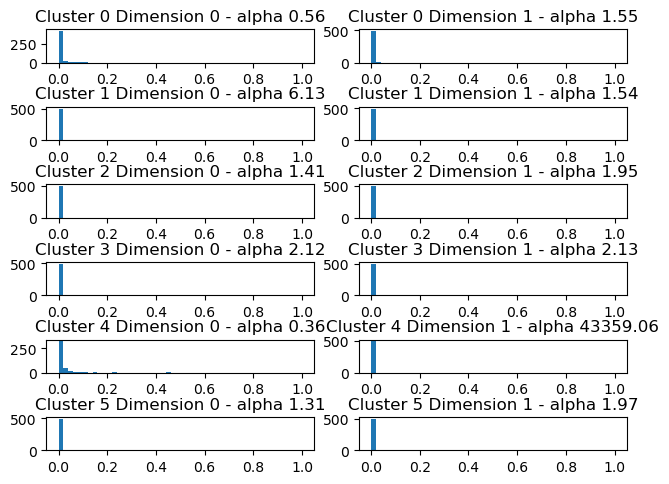

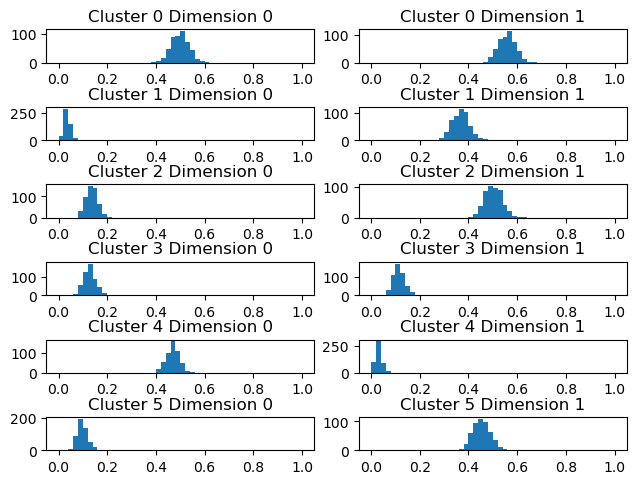

In [41]:
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [42]:
# Without small gaussian noise
mb.params

{'probs_beta': tensor([[4.9749e-01, 5.5456e-01],
         [3.0003e-07, 3.9238e-01],
         [1.3220e-01, 4.9844e-01],
         [1.2257e-01, 1.1104e-01],
         [4.6726e-01, 1.1755e-38],
         [8.7345e-02, 4.5859e-01]]),
 'probs_pareto': tensor([[1.7085e-01, 3.3999e-01],
         [5.2059e-09, 2.4329e-01],
         [3.2595e-02, 4.6196e-03],
         [9.4197e-05, 7.3796e-05],
         [1.2441e-02, 1.1755e-38],
         [9.6471e-03, 2.8112e-03]]),
 'weights': tensor([0.0030, 0.0061, 0.0022, 0.0105, 0.9733, 0.0049]),
 'delta': tensor([[[0.0438, 0.9562],
          [0.3520, 0.6480]],
 
         [[0.8828, 0.1172],
          [0.2628, 0.7372]],
 
         [[0.3159, 0.6841],
          [0.0600, 0.9400]],
 
         [[0.8782, 0.1218],
          [0.4676, 0.5324]],
 
         [[0.8003, 0.1997],
          [0.9806, 0.0194]],
 
         [[0.5446, 0.4554],
          [0.1381, 0.8619]]]),
 'alpha_pareto': tensor([[5.6313e-01, 1.5502e+00],
         [6.1337e+00, 1.5362e+00],
         [1.4109e+00, 1.954